<a id='0'></a><h1 align="center">Содержание </h1> 

- [Метрики](#1)
    - [Accuracy](#2)
    - [Precision и Recall](#3)
    - [f-score](#4)
    - [PR-кривая и ROC-кривая](#5)
        - [PR-кривая](#6)
            - [Идеальная и случайная модели](#7)
        - [ROC-кривая](#8)
             - [Идеальная и случайная модели](#9)
        - [Частный случай ROC и PR на несбалансированных классах](#10)
    - [Выводы по метрикам](#11)

- [Методы](#12)
    - [Data mining](#13)
    - [Preprocessing](#13.1)
    - [Stratification](#14)
    - [Undersampling](#15)
    - [Oversampling](#16)
    - [SMOTE](#17)
    - [Оштрафованные модели](#18)

In [58]:
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [142]:
data = pd.read_csv("../data/credit_card_fraud.zip")
data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [143]:
X, y = data.iloc[:, :-1], data.Class

In [129]:
X.shape

(284807, 30)

In [33]:
counts = data.Class.value_counts()
counts
round(counts[1] / counts[0] * 100, 2)

0    284315
1       492
Name: Class, dtype: int64

0.17

<a id='1'></a><h1 align="center">[Метрики](#0)</h1> 

<img src="../data/Precisionrecall.png" width="300">
$$ \text{Рис. 1. } $$
<img src="../data/positive-negative-true-false-matrix.png" width="300">
$$ \text{Рис. 2. } $$

<a id='2'></a><h3 align="center">[Accuracy](#0)</h3> 

Accuracy - доля верных ответов, количевство верных ответов / объём выборки.

$$ Accuracy = \frac{TP + TN}{TP + FP + FN + TN} $$

В случае несбалансированных классов, данная метрика не подходит, т.к. хорошую точность даёт модель, постоянно предсказывающая преобладающий класс, но т.к. постоянно предсказывается не целевой класс, то пользы от этой модели никакой.

In [6]:
y_true = data.Class
y_pred_zero = [0] * data.shape[0]

value = sum(y_true == y_pred_zero) / data.shape[0]
print(f"Handle accuracy is {round(value * 100, 2)} %")
print(f"Sklearn accuracy is {round(accuracy_score(y_pred_zero, y_true) * 100, 2)} %")

Handle accuracy is 99.83 %
Sklearn accuracy is 99.83 %


Как видим данная модель имеет высокую точность, но не имеет ни какой практической ценности.

Поэтому нужны метрики учитывающие несбалансированность классов.


<a id='3'></a><h3 align="center">[Precision и Recal](#0)</h3> 

Precision - доля объектов целевого класса среди объектов, предсказанных как целевой класс. Насколько мы можем доверять классификатору в случае, если он срабатывает. В случае, если он относит объект к целевому классу.

$$ Precision = \frac{TP}{TP + FP} $$

Recoll - доля правильно предсказанных объектов целевого класса относительно всех объектов целевого класса. Она показывает, как много истинных объектов целевого класса алгоритм выделяет, на скольки из них он срабатывает.

$$ Recoll =  \frac{TP}{TP + FN} $$

<img src="../data/pres-rec.png" width="400">
$$ \text{Рис. 3. } $$

**Проверим модель предсказывающую только преобладающий класс на этих метриках.**

In [7]:
rec = recall_score(y_true, y_pred_zero) * 100
prec = precision_score(y_true, y_pred_zero) * 100
print("Recall is", round(rec, 2))
print("Precision is", round(prec, 2))

Recall is 0.0
Precision is 0.0


Как видим, поскольку целевой класс = 1 то значение TP у модели, постоянно предсказывающая не целевой класс = 0, и из-за этого вышеупомянутые метрики равны 0.

**Рассмотрим другой краевой следующий случай, когда наша модель постоянно предсказывает целевой класс.**

In [8]:
y_pred_one = [1] * data.shape[0]

rec = recall_score(y_true, y_pred_one) * 100
prec = precision_score(y_true, y_pred_one) * 100
print("Recall is", round(rec, 2))
print("Precision is", round(prec, 2))

Recall is 100.0
Precision is 0.17


В этом случае Precision выродилась в Accuracy, а Recall максимален, т.к. такая модель угадывает все объекты целевого класса из имеющихся. 

**Т.е. Recall не учитывает количевство ложных срабатываний**

**Рассмотрим случай, когда предсказываем целевой класс верно, но не полностью, например мы правильно угадали только один раз**

In [9]:
y_pred_one_rigth = [0] * data.shape[0]
y_pred_one_rigth[np.where(y_true == 1)[0][0]] = 1

print("One right answer model recall is", round(recall_score(y_true, y_pred_one_rigth) * 100, 2))
print("One right answer precision is", round(precision_score(y_true, y_pred_one_rigth) * 100, 2))

One right answer model recall is 0.2
One right answer precision is 100.0


Не смотря на то что у нас правильно угадан только один объект целевого класса, precision равна 1, **т.е. precision не учитывает, то сколько целевых объектов мы пропустили, пропусков.**

**Рассмотрим идеальную модель.**

In [10]:
print("Ideal model recall is", recall_score(y_true, y_true) * 100)
print("Ideal model precision is", precision_score(y_true, y_true) * 100)

Ideal model recall is 100.0
Ideal model precision is 100.0


Ожидаемо метрики равны 1, как видно из формул.

**В итоге по Recall и Precision. **
- Максимизация метрики Recall ведет в к тому, что модель помимо объектов целевого класса имеет ложные срабатывания на объектах не целевого класса


- Маскимизация precision приводит к тому что мы пропускаем часть объектов целевого класса.

Использование данных метрик для построение модели имеет смысл. 

- Модель с максимизацией recall жизнеспособна в случаях, когда цена ошибки высока, а цена проверки ложных сробатываний нет, например в медицине и банковской сфере.


- В случае если цена ошибки очень высока, например мы ограничены в ресурсах, то есть смысл максимизировать precision, т.к. мы не можем позволить себе не целевое использование ресурсов.


<a id='4'></a><h3 align="center">[F-score](#0)</h3> 

В случае если мы хотим минимизировать пропуски и ложные срабатывания, то нам нужно работать и с recall и c precision, для таких случаев используется гармоническое среднее между recall и precision - $F$-мера.

$$ F = 2 \cdot \left( \frac{1}{Recall} + \frac{1}{Precision} \right)^{-1} = 2\frac{Recall \cdot Precision}{Recall + Precision} $$

F мера стремится к 0 когда Precision и/или Recall стремятся к 0, и F стремится к 1 когда обе величины стремятся к 1.

<img src="../data/F-1.png" width="400">
$$ \text{Рис. 4. Сбалансированная F-мера} $$
  
В случае если мы всё же отдаем предочтение одной из метрик Precision или Recall, но хотим учесть и недостатки такого предпочтения, то можно использовать $F$ меру с коэффициентом $\beta$

$$ F_\beta = (\beta^2 + 1)\frac{Recall \cdot Precision}{\beta^2 \cdot Precision + Recall} $$

где $\beta$ принимает значения в диапазоне $ 0 < \beta < 1$ если вы хотите отдать приоритет recall (recall вносит больший вклад чем precision), а при $\beta > 1$ приоритет отдается precision. При $\beta = 1$ формула сводится к предыдущей и вы получаете сбалансированную $F$-меру, .

<img src="../data/F-1-over-4.png" width="400">
$$ \text{Рис. 5. F-мера с приоритетом recall } (\beta^2=\frac{1}{4}) $$
  
<img src="../data/F-2.png" width="400">
$$ \text{Рис. 6. F-мера с приоритетом precision } (\beta^2 = 2) $$

<a id='5'></a><h3 align="center">[PR-кривая и ROC-кривая](#0)</h3> 

Чтобы говорить о дальнейших метриках, нужно уточнить что дальше будут использоваться результаты модели не в виде принадлежности объекта к какому-либо классу, а **вероятности** принадлежности (**predict_proba**) объекта к целевому классу.

Введем порог (threshold) - вероятность выше которой объект относится к целевому классу.

$$ \text{y_predict(x, threshold)} = [\text{predict_proba(x)} > \text{threshhold}] $$

***Тогда двигая threshold от 1, вероятность при которой ни один объект не будет отнесен к целевому классу, до 0, вероятность при которой все объекты буду отнесены к нецелевому классу, измерем метрики (сравнивая полученные предсказания с истинными). В итоге мы получаем описание качества нашей модели, в пространсве измеряемых метрик***


В этих терминах простой метод, сразу выдающий предсказание о принадлежности объекта к классу, можно рассматривать как вышеуказанную модель с threshold = 0.5, т.е. $ \text{y_predict(x)} = [\text{predict_proba(x)} > 0.5] $.

<a id='6'></a><h3 align="center">[PR-кривая](#0)</h3> 

PR-кривая строится по выше упомянутому методу в метриках Precision от Recall. 

Построим её на игрушечном примере

In [11]:
predict_proba = np.array([0.14, 0.23, 0.39, 0.52, 0.73, 0.90])
y_true = np.array([0, 1, 0, 0, 1, 1])

Сначала возьмем порог, при котором ни один объект не будет отнесен к классу 1. В этом случае и точность, и полнота равны нулю. Ставим точку (0, 0). Далее чуть-чуть уменьшаем порог так, чтобы ровно один объект с максимальной оценкой был отнесен к классу 1. В этом случае точность будет равна 100 %, полнота будет равна 1 / 3, поскольку мы выделяем один из трех положительных объектов. Ставим следующую точку. При дальнейшем уменьшении порога мы два объекта отнесем к первому классу, и оба будут верными срабатываниями — точность все еще равна 100 %, полнота увеличивается до 2 / 3. Далее, когда мы три объекта отнесем к первому классу, то точность уменьшится, поскольку третий относится к негативному классу, на самом деле, — точность станет равна 2 / 3, — полнота останется такой же. Уменьшаем порог еще сильнее — точность уменьшается, полнота остается такой же. Когда мы отнесем пять объектов к первому классу, точность окажется равной 3 / 5, а полнота будет 100 %, поскольку мы уже выделили все объекты первого класса. Наконец, когда мы все объекты отнесем к классу... классу 1, то получим, что точность равняется 1 / 2, полнота равняется 100 %. 

In [13]:
precision = []
recall = []

for threshold in np.linspace(0, 1, 10):
    y_pred = (predict_proba > threshold).astype(int)
    precision.append(precision_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))

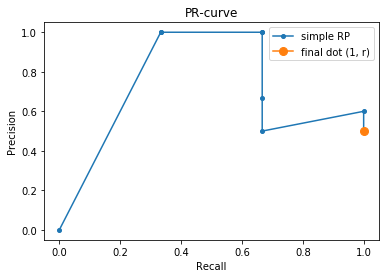

In [14]:
plt.plot(recall, precision, label="simple RP", marker="o", markersize=4)
plt.plot(recall[0], precision[0], markersize=8, marker='o', label="final dot (1, r)")

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve");

<a id='7'></a><h4 align="center"> [Идеальная и случайная модели](#0) </h4> 

In [15]:
np.random.seed(42)
size = 10000

y_true = np.random.choice((0, 1), size=size, p=(1-0.17, 0.17))

random_model = np.random.uniform(size=size)

ideal_model = np.zeros(size, dtype=float)
ideal_model[np.where(y_true == 1)] = np.random.uniform(0.6, 1, size=y_true.sum())
ideal_model[np.where(y_true == 0)] = np.random.uniform(0, 0.4, size=size - y_true.sum())

prec_rand = []
rec_rand = []
prec_ideal = []
rec_ideal = []

for threshold in np.linspace(0, 1, 1000):
    y_rand = (random_model > threshold).astype(int)
    y_ideal = (ideal_model > threshold).astype(int)
    
    prec_rand.append(precision_score(y_true, y_rand))
    rec_rand.append(recall_score(y_true, y_rand))
    
    prec_ideal.append(precision_score(y_true, y_ideal))
    rec_ideal.append(recall_score(y_true, y_ideal))

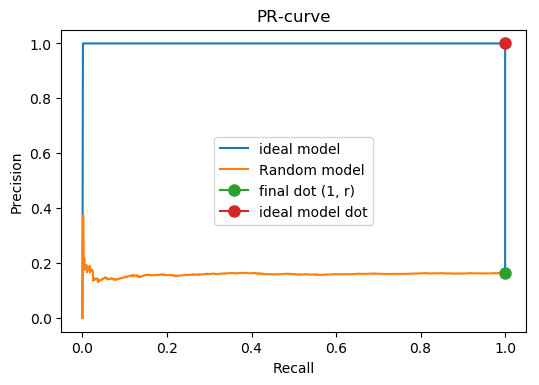

In [16]:
plt.figure(dpi=100)
plt.plot(rec_ideal, prec_ideal, label="ideal model")
plt.plot(rec_rand, prec_rand, label="Random model")
plt.plot(rec_ideal[0], prec_ideal[0], markersize=8, marker='o', label="final dot (1, r)")
plt.plot([1], [1], markersize=8, marker='o', label="ideal model dot")

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve");

<img src="../data/pr-curve.png" width="400">
$$ \text{Рис. 7. Реальная PR-кривая на большом количестве данных }$$

Финальная точка этой кривой находится по координатам 1 и r, полнота равняется 100 %, а точность равняется доли объектов первого класса во всей выборке. Если у нас имеется идеальный классификатор, то и существует такой порог, при котором и точность, и полнота — 100%, то кривая пройдет через точку (1, 1). Чем ближе к этой точке она пройдет, тем лучше наши оценки.


Таким образом, площадь под этой кривой может быть хорошей мерой качества оценок принадлежности к классу 1. 

**Метрика площади под кривой называется AUC — PR, или площадь под precision-recall-кривой.**

Площадь под precision-recall-кривой зависит от точности и полноты. При этом в точности нормировка производится на число срабатываний алгоритма. 

- Таким образом, если соотношение классов изменится, то изменится и точность, **значит и площадь под precision-recall-кривой зависит от соотношения классов.** 

<a id='8'></a><h3 align="center">[ROC-кривая](#0)</h3> 

Метрики используемые для построения ROC-кривой:
- По оси абсцис - доля верных срабатываний (True Positive Rate, TPR - отношение числа верных срабатываний, к общему размеру целевого класса), $TPR = \frac{TP}{TP + FN}$
- По оси ординат - доля ложных срабатываний (False Positive Rate, FPT -  отношение числа ложных срабатываний, к общему размеру нецелевого класса), $FPR = \frac{FP}{FP + TN}$

Разберем на том же примере, как строится ROC-кривая. Сначала выбираем порог, при котором ни один объект не относится к первому классу. Получаем точку (0, 0) — доля верных срабатываний, доля ложных срабатываний равны 0. Далее, когда мы один объект отнесем к классу 1, доля верных срабатываний увеличится на 1 / 3, доля ложных срабатываний останется нулевой. При дальнейшем уменьшении порога доля верных срабатываний увеличится до 2 / 3, доля ложных срабатываний — все еще 0. Отнесем три объекта к классу 1. В этом случае доля верных срабатываний все еще равна 2 / 3, доля ложных срабатываний — 1 / 3. Уменьшаем еще сильнее — доля верных срабатываний остается такой же, доля ложных срабатываний увеличивается до 2 / 3. Далее, доля верных срабатываний увеличивается до 1, доля ложных срабатываний останется 2 / 3. И, наконец, когда все объекты отнесем к классу 1, доля и верных, и ложных срабатываний будет равна 1. 

In [17]:
predict_proba = np.array([0.14, 0.23, 0.39, 0.52, 0.73, 0.90])  # результат обычной модели
y_true = np.array([0, 1, 0, 0, 1, 1])
TPR, FPR = [], []

for threshold in np.linspace(0, 1, 10):
    y_pred = (predict_proba > threshold).astype(int);
    (TN, FP), (FN, TP) = confusion_matrix(y_true, y_pred)
    TPR.append(TP/(TP + FN))
    FPR.append(FP/(FP + TN))

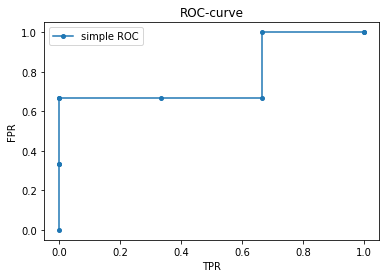

In [18]:
plt.plot(FPR, TPR, label="simple ROC", marker="o", markersize=4)

plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC-curve");

<a id='9'></a><h4 align="center"> [Идеальная и случайная модели](#0) </h4> 

In [19]:
np.random.seed(42)
size = 10000

y_true = np.random.choice((0, 1), size=size, p=(1-0.17, 0.17))

TPR_rand, FPR_rand, TPR_ideal, FPR_ideal = [], [], [], []

for threshold in np.linspace(0, 1, 1000):
    y_rand = (random_model > threshold).astype(int)
    y_ideal = (ideal_model > threshold).astype(int)
    
    (TN_i, FP_i), (FN_i, TP_i) = confusion_matrix(y_true, y_ideal)
    (TN_r, FP_r), (FN_r, TP_r) = confusion_matrix(y_true, y_rand)
        
    TPR_rand.append(TP_r/(TP_r + FN_r))
    FPR_rand.append(FP_r/(FP_r + TN_r))
    
    TPR_ideal.append(TP_i/(TP_i + FN_i))
    FPR_ideal.append(FP_i/(FP_i + TN_i))

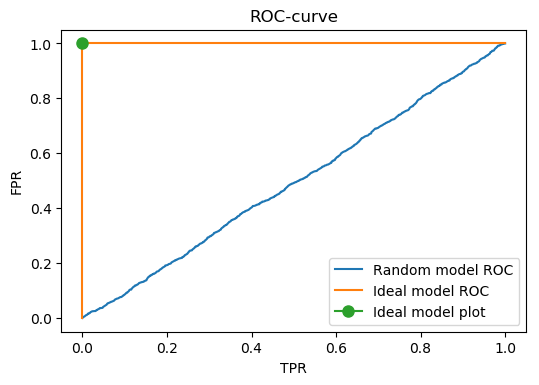

In [20]:
plt.figure(dpi=100)
plt.plot(FPR_rand, TPR_rand, label="Random model ROC")
plt.plot(FPR_ideal, TPR_ideal, label="Ideal model ROC")
plt.plot([0], [1], label="Ideal model plot", markersize=8, marker='o')

plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC-curve");

<img src="../data/roc-curve.png" width="400">
$$ \text{Рис. 8. Реальная ROC-кривая на большом количестве данных }$$

В случае с большой выборкой ROC-кривая выглядит следующим образом (Рис. 8). Она стартует из точки (0, 0) и приходит в точку (1, 1), при этом если есть идеальный классификатор, то его доля верных ответов будет равна 1, доля ложных срабатываний будет равна 0, то есть кривая пройдет через точку (0, 1). 

Опять же, чем ближе кривая к этой точке, тем лучше наши оценки, и площадь по этой кривой будет характеризовать качество оценок принадлежности к первому классу. **Эта метрика называется AUC — ROC, или площадь под ROC-кривой.**

Вспомним, что она ROC-кривая строится на доле верных и ложных срабатываний. При этом доля ложных срабатываний делится на размер негативного класса, доля верных срабатываний делится на размер положительного класса. **За счет того, что эти величины делятся на объемы классов, площадь под ROC-кривой не зависит от баланса классов.** Если свойства объектов выборки останутся такими же, но лишь изменится соотношение классов, площадь под ROC-кривой не изменится. 


Площадь под ROC-кривой для идеального алгоритма равна 1, площадь под ROC-кривой для худшего алгоритма, то есть того, который выдает случайные ответы, находится в районе 1 / 2. 


При этом у площади под ROC-кривой есть много интересных интерпретаций, которые помогают объяснять ее другим людям. Например, она равняется вероятности того, что если вы выберете случайный положительный и случайный отрицательный объект из выборки, то положительный объект получит оценку принадлежности выше, чем отрицательный объект

<a id='10'></a><h4 align="center">[Частный случай для PR и ROC кривых](#0)</h4> 

Площадь под precision-recall-кривой проще интерпретировать, если выборка сильно несбалансированная. Давайте разберем это на примере. Представьте, что мы построили такие оценки принадлежности, что максимальные оценки — у 50 тысяч объектов отрицательного класса. Далее идут 100 объектов положительного класса. И далее — 950 тысяч объектов отрицательного класса. У нас очень большой отрицательный класс — миллион объектов, и маленький положительный — 100 объектов. И при этом, при такой сортировке, при таком упорядочивании, 100 объектов положительного класса оказались довольно далеко от верха — сначала идет 50 тысяч отрицательных объектов. Понятно, что такая сортировка нас не устраивает — положительные объекты находятся слишком далеко. При этом площадь под ROC-кривой равняется 95 %, площадь под precision-recall-кривой — 0,1 %.


In [21]:
size = 1000000
y_true = np.zeros(size)
y_true[50001:50101] = 1

sample_prob = np.zeros(size)
sample_prob[:50000] = np.random.uniform(0.91, 1, size=50000)
sample_prob[50000:50100] = np.random.uniform(0.81, 0.9, size=100)
sample_prob[50100:] = np.random.uniform(0, 0.8, size=size-50100)

In [29]:
counts = 100
TPR, FPR, precision, recall = (np.zeros(counts, dtype=float) for _ in range(4))

for i, threshold in enumerate(np.linspace(0, 1, counts)):
    y_pred = (sample_prob > threshold).astype(int);
    
    (TN, FP), (FN, TP) = confusion_matrix(y_true, y_pred)
    
    TPR[i] = TP/(TP + FN)
    FPR[i] = FP/(FP + TN)
    
    precision[i] = precision_score(y_true, y_pred)
    recall[i] = recall_score(y_true, y_pred)

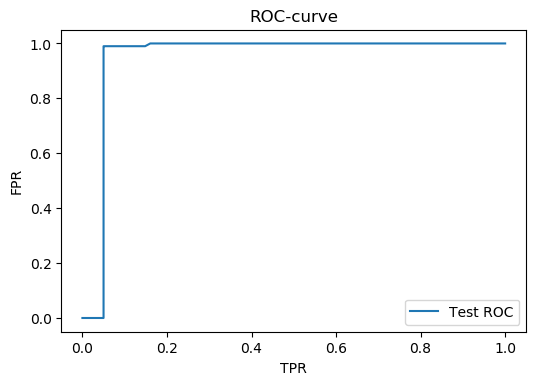

In [30]:
plt.figure(dpi=100)
plt.plot(FPR, TPR, label="Test ROC")
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC-curve");

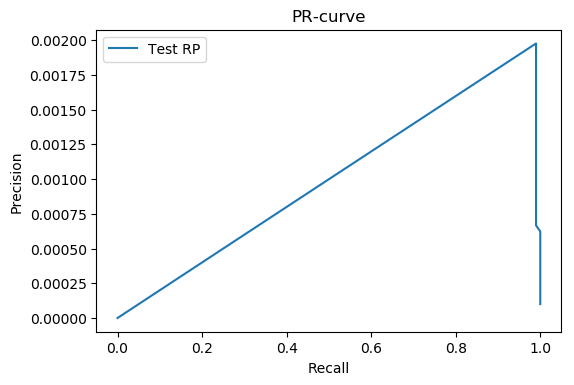

In [31]:
plt.figure(dpi=100)
plt.plot(recall, precision, label="Test RP")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve");

Площадь под ROC-кривой получилась большой, это может ввести в заблуждение. Давайте разберемся, почему так вышло. Чтобы понять, давайте рассмотрим одну точку в пространстве ROC-кривой. Возьмем порог, при котором к первому классу будут отнесены 50 тысяч объектов негативного класса и 95 объектов позитивного класса. Понятно, что это не очень хороший классификатор — у него слишком много ложных срабатываний. Их будет 50 тысяч, при этом верных срабатываний — 95. Доля верных срабатываний равна 95 %, доля ложных срабатываний равна всего 5 %, поскольку в ней нормировка производится на размер всего отрицательного класса. А 50 тысяч — это очень мало, по сравнению с миллионом объектов во всем отрицательном классе. Понятно, что эта точка лежит близко к точке с координатами (0, 1), и поэтому ROC-кривая очень похожа на идеальную — площадь под ней близка к 1. При этом точность и полнота этого алгоритма гораздо лучше отражают ситуацию. Полнота равняется 95 %, а точность — меньше 1 %, поскольку слишком много ложных срабатываний. 


**Таким образом, площадь под кривой точности-полноты гораздо лучше отражает ситуацию в данном примере с несбалансированными выборками.**

<a id='11'></a><h3 align="center">[Выводы по метрикам](#0)</h3> 

У нас задача поиск мошенничесва с кредитными картами с сильным дисбалансом в классах.

Обычно в таких задачах хочется поймать как больше можно нарушителей, и банки зачастую имеют достаточно ресурсов для этого. Для решения этой задачи подойдут следующие метрики

- Accuracy. Данную метрику можно использовать, *но в этом случае приемлемая для нас точность лежит в области **[доля нецелевого класса, 1]***. 
  
  
- Recall и Precision. Мы можем стараться максимизировать Recall и следить за тем, чтоб модель не выродилась в предсказание целевого класса. Или можно выбирать такой treshold чтобы Recall был большим (80%+), и стараться улучшать Precision нашей модели.
  
  
- $f_{\beta}-score$, f мера с приоритетом Recall ( например с $\beta = \frac{1}{2}$).
  
  
- ROC-AUC и PR-AUC. Площади под кривыми ROC, PR. Их обе можно применять, но PR-AUC более выразительна в случае несбалансированных классов, как было показано выше.


___
___
___
<a id='12'></a><h1 align="center">[Методы](#0)</h1> 

<a id='13'></a><h3 align="center">[Data mining](#0) </h3> 

Если данных не достаточно, то можно попробовать добыть еще. Machine Learning Group - ULB предоставили только один датасет и данные в нём анонимные, поэтому найти дополнительные данные, заданной размерности не предоставляется возможным

<a id='13.1'></a><h3 align="center">[Preprocessing](#0) </h3> 

Предобработка данных стандартная процедура перед полноценной работы с моделями, например работа с пропусками, нормализация данных для лучшей сходимости процессов автомизации, feature engineering и т.д. Предобработка данных в МЛ одна из основных причин улучшения качества итоговой модели.

In [39]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


В нашем случае отнормируем признаки.

In [217]:
data = pd.read_csv("../data/credit_card_fraud.zip")
X, y = data.iloc[:, :-1], data.Class
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=data.columns[:-1])
X.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.050379e-14,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,...,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.996583e+00,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,-8.552120e-01,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,-2.131453e-01,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,9.372174e-01,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,1.642058e+00,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


<a id='14'></a><h3 align="center">[Stratification](#0)</h3> 

Обратим внимание на проблему, с которой можно столкнуться при работе с несбалансированными выборками. Когда мы проводим кросс-валидацию, мы разбиваем исходную выборку на k блоков примерно одинаковой длины.

При этом если выборка несбалансированная и, например, первого класса очень мало, то при таком разбиении может оказаться, что в некоторые блоки объекты первого класса не попадут вообще. Это будет очень плохо. Например, при обучении на этом блоке мы получим классификатор, который никогда не видел один из классов. 

Чтобы бороться с этим, нужно делать стратификацию. При стратификации мы строим разбиение на блоки так, чтобы распределение классов в каждом блоке примерно совпадало с распределением классов в исходной выборке. В этом случае будет гарантироваться, что объекты каждого класса будут представлены в каждом из блоков разбиения.



In [187]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import precision_recall_curve, auc


seed = 42
splits = 5
np.random.seed(seed)
clf = RandomForestClassifier(min_samples_leaf=10, n_jobs=-1)  # поставим ограничения, чтоб уменьшить перееобучение
good_accuracy = data.Class.value_counts()[0]/data.shape[0]
good_accuracy

0.9982725143693799

In [215]:
kf = KFold(n_splits=splits, random_state=seed)
recall, precision, accuracy = [], [], []
pr_auc = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    clf.fit(X_train, y_train);
    y_pred = clf.predict(X_test);
    
    recall.append(recall_score(y_test, y_pred));
    precision.append(precision_score(y_test, y_pred));
    accuracy.append(accuracy_score(y_test, y_pred));
    
    y_proba = clf.predict_proba(X_test)
    prec, rec, thr = precision_recall_curve(y_test, y_proba[:, 1], pos_label=1)
    pr_auc.append(auc(rec, prec))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [180]:
print(accuracy - good_accuracy)

[0.00063904 0.0011306  0.00104281 0.00137637 0.00121837]


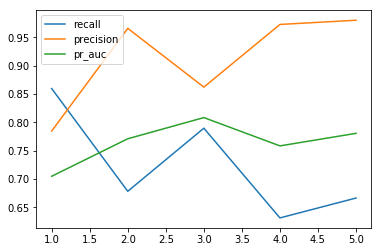

In [216]:
x = range(1, 6)
plt.plot(x, recall, label="recall")
plt.plot(x, precision, label="precision")
plt.plot(x, pr_auc, label="pr_auc")
plt.legend();

In [211]:
skf = StratifiedKFold(n_splits=splits, random_state=seed)
recall, precision, accuracy = [], [], []
pr_auc = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train);
    y_pred = clf.predict(X_test);
    
    recall.append(recall_score(y_test, y_pred));
    precision.append(precision_score(y_test, y_pred));
    accuracy.append(accuracy_score(y_test, y_pred));
    
    y_proba = clf.predict_proba(X_test)
    prec, rec, thr = precision_recall_curve(y_test, y_proba[:, 1], pos_label=1)
    pr_auc.append(auc(rec, prec))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [212]:
accuracy - good_accuracy, good_accuracy

(array([0.00070926, 0.00127104, 0.00079702, 0.00134126, 0.00113059]),
 0.9982725143693799)

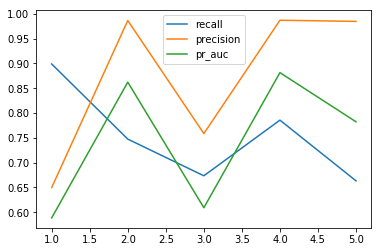

In [213]:
x = range(1, 6)
plt.plot(x, recall, label="recall")
plt.plot(x, precision, label="precision")
plt.plot(x, pr_auc, label="pr_auc")
plt.legend();

In [237]:
pr_auc

[0.7050648744351319,
 0.7712583046026529,
 0.8085956434359793,
 0.7586898018132141,
 0.7808324758128327]

**В целом стратификация про более корректную оценку получившейся модели, нежели чем про улучшение итогового качества оценки модели в проде**


<a id='15'></a><h3 align="center">[Undersampling](#0)</h3> 

Его основная идея состоит в том, что нам не нужно много примеров объектов из больших классов, можно выкинуть часть из них. Например, представьте, что у нас есть три класса: первый — очень большой; второй — совсем маленький; и третий имеет средний размер. В этом случае мы выкинем большую часть объектов первого класса и половину объектов третьего класса. В этом случае размеры классов примерно сравняются.

<img src="../data/undersampling.png" width="400">

**При этом то, сколько именно объектов каждого класса мы выбрасываем, это гиперпараметр, который имеет смысл настраивать по отложенной выборке или на кросс-валидации.**

Лучше всего использовать некий критерий, по которому стоит отсортировать данные и выбрать самые ценные из нецелевого класса, а все остальные отбросить, но поскольку данные анонимные, то воспользуемся готовым решением.

In [219]:
from imblearn.under_sampling import NearMiss

In [238]:
pr_auc

[0.7050648744351319,
 0.7712583046026529,
 0.8085956434359793,
 0.7586898018132141,
 0.7808324758128327]

In [272]:
nm = NearMiss(ratio=.3)
X_under, y_under = nm.fit_resample(X, y)

In [273]:
clf.fit(X_under, y_under);
y_prob = clf.predict_proba(X);
y_pred = clf.predict(X);

In [274]:
prec, rec, thr = precision_recall_curve(y, y_prob[:, 1], pos_label=1)
auc(rec, prec)

0.6687231000842638

In [275]:
recall_score(y, y_pred)
precision_score(y, y_pred)

0.9308943089430894

0.0035204501256754575

In [276]:
accuracy_score(y, y_pred)

0.5446986906922934

Как видим данный способ не улучшил метрику PR-AUC

**Минус данного метода в том, что мы обрасываем ценную информацию, хоть и не целевого класса**

<a id='16'></a><h3 align="center">[Oversampling](#0)</h3> 

Он противоположен предыдущему. Мы будем дублировать объекты маленьких классов так, чтобы выравнять соотношение классов. В нашем примере мы пять раз повторим объекты второго класса, а для третьего класса мы возьмем случайную половину объектов и продублируем их. Таким образом третий класс мы увеличим в полтора раза. В этом случае размеры выборок, размеры классов тоже выравняются. То, насколько мы будем увеличивать каждый класс, – это тоже гиперпараметр. 

<img src="../data/oversampling.png" width="400">

Обратим внимание на одну особенность. Если мы решаем задачу на исходной выборке, то, например, среднеквадратичная ошибка будет выглядеть вот так.

$$ \large MSE(a, X) = \frac{1}{l}\sum_i^l(a(x_i) - y_i)^2 $$

Это среднее значение квадратичной ошибки по всем объектам. Если же мы делаем oversampling, то есть дублируем какие-то объекты, то это будет означать, что какое-то слагаемое войдет в эту сумму несколько раз. Таким образом, вместо реального дублирования объектов, мы можем просто выставить соответствующие веса при каждом слагаемом.

$$ \large MSE(a, X, v_i) = \frac{1}{l}\sum_i^l v_i (a(x_i) - y_i)^2 $$

Например, если первый объект мы продублируем три раза, то мы просто выставим вес при нем равным трем, $v_1 = 3$. 

**Минус данного метода в том, что наша модель переобучается на объектах целевого класса, и из-за этого  предсказание целевого класса может ухудшиться**

<a id='17'></a><h3 align="center">[Синтетические образцы, SMOTE](#0)</h3> 




TODO

<a id='18'></a><h3 align="center">[Оштрафованные модели, штраф через параметр модели](#0)</h3> 

TODO